# 1. Importing basic libraries and the dataset

In [25]:
# Basic libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
df = pd.read_csv('train.csv')
df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# Check the datatypes of each column
df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

# 2. Data cleaning

In [4]:
# Remove the column for ID
ids = df['Id']
df.drop('Id', axis=1, inplace=True)

In [5]:
# Fill the empty numerical data with 0
for col in df.columns:
    if df[col].dtype != 'object':
        df[col] = df[col].fillna(0)

In [6]:
df.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# 3. Converting categorical values into numerical values with one-hot encoding

In [7]:
# Obtain categorical columns
cat_cols = df.select_dtypes(include='object').columns.tolist()

# One-hot encoding for categorical columns (inputs)
df1 = pd.get_dummies(df, columns=cat_cols)

In [8]:
# Check dataset structure to confirm that one-hot encoding has been applied
print(df1.head(5))

   MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0          60         65.0     8450            7            5       2003   
1          20         80.0     9600            6            8       1976   
2          60         68.0    11250            7            5       2001   
3          70         60.0     9550            7            5       1915   
4          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLw  \
0          2003       196.0         706           0  ...           False   
1          1976         0.0         978           0  ...           False   
2          2002       162.0         486           0  ...           False   
3          1970         0.0         216           0  ...           False   
4          2000       350.0         655           0  ...           False   

   SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0         False  

# 4. Training the random forest model

In [9]:
# Separate features and target
X = df1.drop('SalePrice', axis=1)
y = np.log1p(df1['SalePrice'])

# Split into train and validation sets
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, ids, test_size=0.2, random_state=42
)

In [10]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Initialize the RandomForestRegressor
rf_model = RandomForestRegressor(random_state=30, n_jobs=-1)

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Output the best parameters found during the grid search
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


In [11]:
# Output the best parameters found during the grid search
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


# 5. Input test data into the random forest model to obtain the predicted SalePrice

In [12]:
# Fit the test data into the model
rf_model = grid_search.best_estimator_
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                      n_jobs=-1, random_state=30)

In [13]:
# Obtain the predicted value of saleprice
test_preds_log = rf_model.predict(X_test)
test_preds = np.expm1(test_preds_log)

In [14]:
# Store the data into a pandas dataframe
df_final = pd.DataFrame({
    'Id': ids_test,
    'SalePrice': test_preds
})

In [15]:
df_final.head(5)

,Id,SalePrice
892,893,139763.360021
1105,1106,319683.284021
413,414,115937.020856
522,523,153531.228319
1036,1037,302920.695643


In [23]:
y_test_actual  = np.expm1(y_test)

rmse = np.sqrt(mean_squared_error(y_test_actual, test_preds))
print("RMSE (original scale):", rmse)

RMSE (original scale): 29849.777972978634


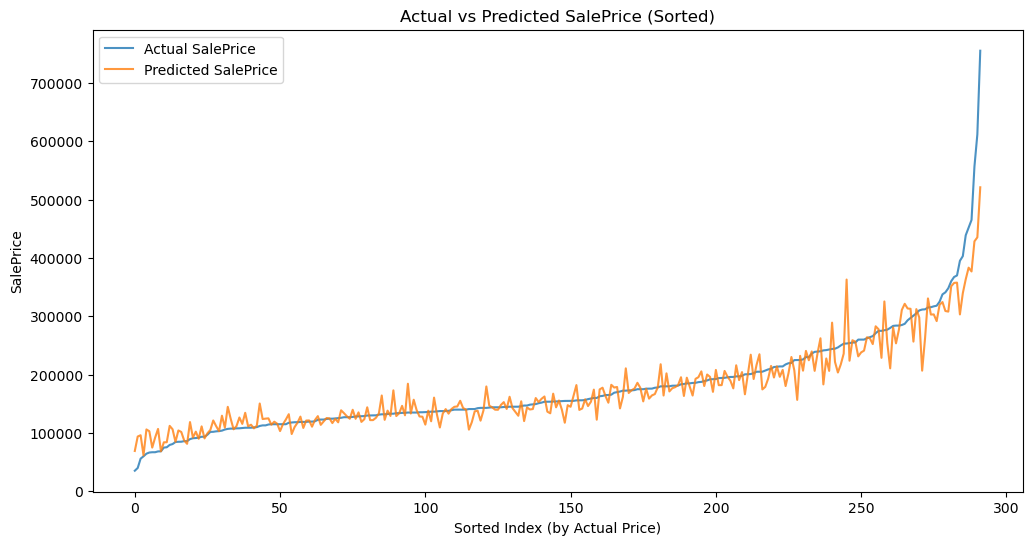

In [20]:
order = np.argsort(y_test_actual.values)

plt.figure(figsize=(12, 6))

plt.plot(
    y_test_actual.values[order],
    label="Actual SalePrice",
    alpha=0.8
)

plt.plot(
    test_preds[order],
    label="Predicted SalePrice",
    alpha=0.8
)

plt.xlabel("Sorted Index (by Actual Price)")
plt.ylabel("SalePrice")
plt.title("Actual vs Predicted SalePrice (Sorted)")
plt.legend()
plt.show()
